# Ensemble learning

## Voting과 Bagging 개요

보팅과 배깅은 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식

보팅과 배깅의 차이점 
> 보팅의 경우 일반적으로 서로 다른 알고리즘을 결합하는 것\
\
배깅의 경우 각각의 분류기가 모두 같은 유형의 알고리즘 기반이지만 데이터 샘플링을 서로 다르게 가져가면서 학습을 수행해 보팅을 수행

### 보팅 유형

> Hard Voting은 다수의 Classifier 간 다수결로 최종 class 결정\
\
Soft Voting은 다수의 Classifier들의 class 확률을 평균하여 결정

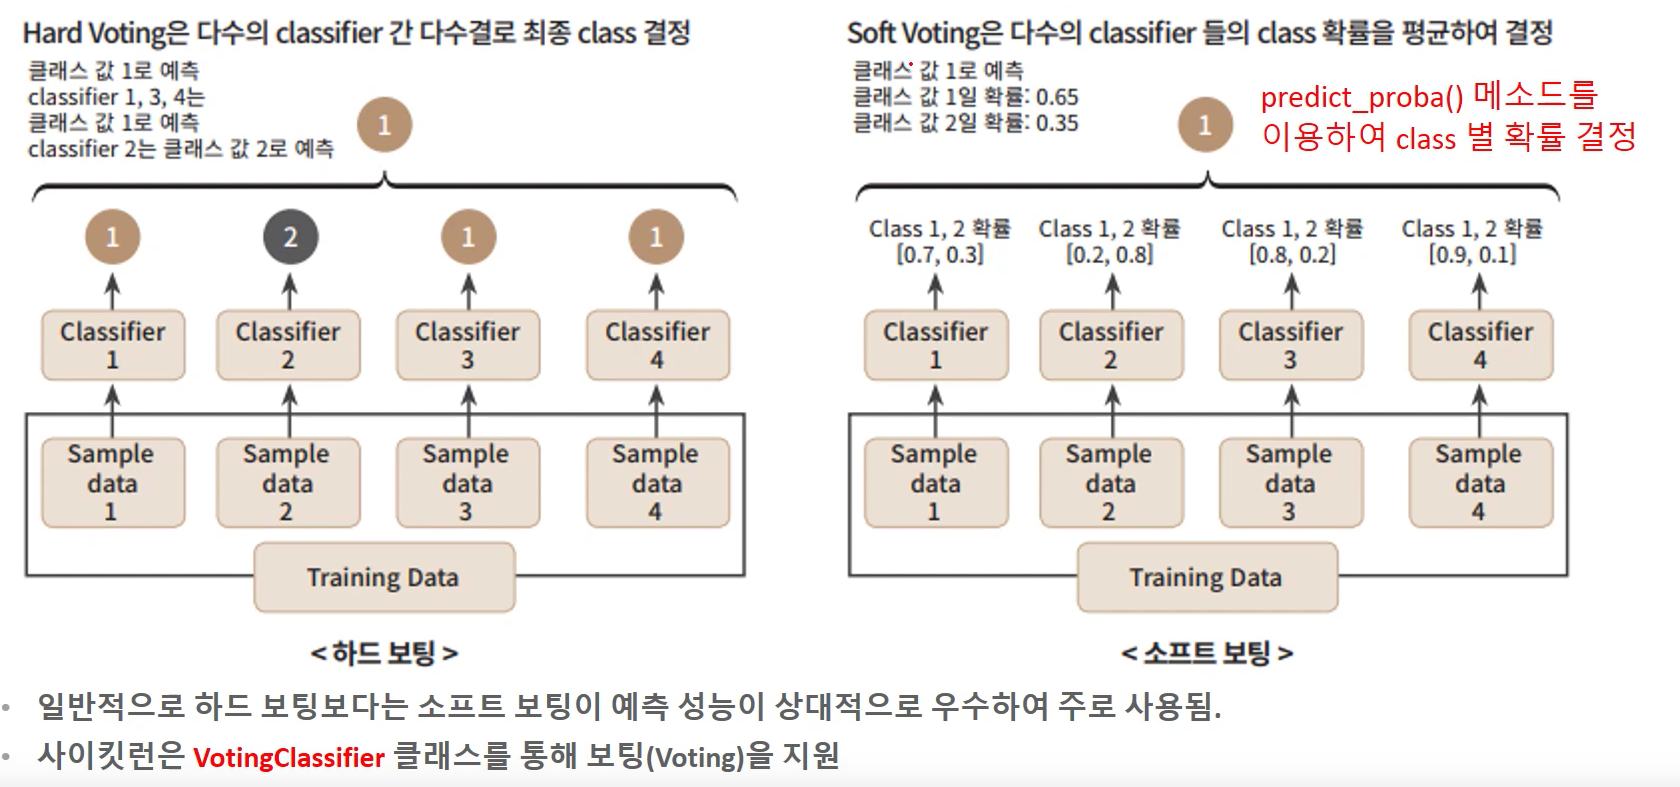

**위스콘신 유방암 데이터 로드**

In [3]:
import pandas as pd 

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(data = cancer.data, columns = cancer.feature_names)

In [4]:
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


**VotingClassifier로 개별 모델 로지스틱 회귀와 KNN을 보팅 방식으로 결합하고 성능 비교**

In [12]:
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors = 8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators = [('LR', lr_clf), ('KNN', knn_clf)], voting = 'soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size = 0.2, random_state = 156)

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Voting 분류기 정확도 : {0:.4f}'.format(accuracy))

# 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers : 
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도 : {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도 : 0.9474
LogisticRegression 정확도 : 0.9386
KNeighborsClassifier 정확도 : 0.9386


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

### 배깅 - 랜덤 포레스트

**RandomForestClassifier 하이퍼 파라미터**
> `n_estimators`:랜덤 포레스트에서 결정 트리의 개수, 많을수록 좋은 성능을 기대할 수 있지만 무조건 향상되는 것은 아니고 시간도 오래 걸린다\
    \
    `max_features`는 결정 트리에 사용된 max_features 파라미터와 같지만 RandomForestClassifier의 기본 max_features는 'None'이 아니라 'auto' 즉, 'sqrt'\
    \
   ` max_depth`나 `min_samples_split`처럼 결정 트리에서 과적합을 개선하기 위해 사용되는 파라미터가 랜덤 포레스트에서도 똑같이 적용될 수 있음

In [19]:
import pandas as pd 

def get_new_feature_name_df(old_feature_name_df) : 
    feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), columns = ['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis = 1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis = 1)
    return new_feature_name_df

In [20]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as np
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

In [25]:
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도 : 0.9253


GridSearchCV로 교차검증하여 하이퍼 파라미터 튜닝

In [27]:
from sklearn.model_selection import  GridSearchCV

params = {
    'n_estimators' : [100],
    'max_depth' : [6,8,10,12],
    'min_samples_leaf' : [8,12,18],
    'min_samples_split' : [8,16,20]
}

rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터 : \n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터 : 
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도 : 0.9180


**튜닝된 하이퍼 파라미터로 재학습 및 예측/평가**

In [28]:
rf_clf1 = RandomForestClassifier(n_estimators = 300, max_depth = 10, min_samples_leaf = 8, \
                                min_samples_split = 8, random_state = 0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도 : 0.9165


**개별 Feature들의 중요도 시각화**

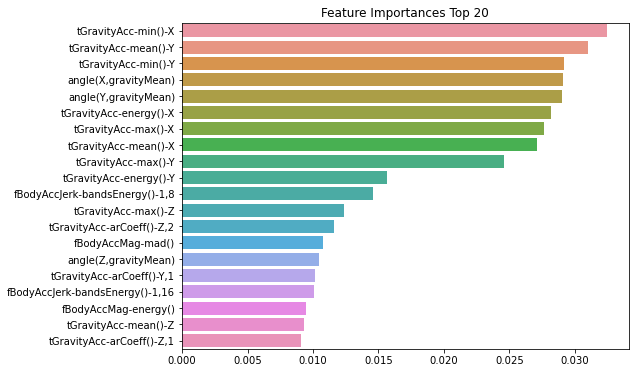

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8,6))
plt.title('Feature Importances Top 20')
sns.barplot(x = ftr_top20, y = ftr_top20.index)
plt.show()

**사이킷런 GBM 주요 하이퍼파라미터 튜닝**
> `loss` : 경사 하강법에서 사용할 비용 함수를 지정. 특별한 이유가 없으면 default인 'deviance'를 그대로 적용\
\
`learning_rate` : GBM이 학습을 진행할 때마다 적용하는 학습률(Weak learner가 순차적으로 오류값을 보정해나가는 데 적용하는 계수로 0~1 사이의 값을 지정할 수 있으며 기본값은 0.1이다. 너무 작은 값을 적용하면 업데이트되는 값이 작아져서 예측 성능이 높아질 가능성이 높지만 수행 시간이 오래걸리고 너무 작은 경우에는 반복이 끝나도 최소 오류값을 찾지 못할 수도 있다. 반대로 너무 큰 값을 적용하면 최소 오류값을 지나쳐버릴 수도 있지만 빠른 수행이 가능하다\
\
`n_estimators` : weak learner의 개수로 개수가 많을수록 예측 성능이 일정 수준까지는 좋아질 수 있으나 수행 시간이 오래걸린다. 기본값은 100\
\
`subsample` : 학습에 사용하는 데이터의 샘플링 비율로 기본값은 1. 1의 경우 전체 학습 데이터를 기반으로 학습한다는 의미이다. 과적합이 염려되는 경우 subsample을 1보다 작은 값으로 설정
